# Frame the Problem and Look at the Big Picture 

1. Define the objective in business terms.
- The objective is to predict which squirrels are 
   sick and which are healthy.<!-- (I think confirm this derek) -->-
- our client is part of the Squirrel census and is interested in the health of the squirrels in Central Park.
- The goal is to predict weather or not a squirrel has a certain disease or not.
2. How will your solution be used?
- The solution will be used to predict the health of the squirrels in Central Park. This could save time and money for the Squirrel census.
3. What are the current solutions/workarounds (if any)?
- The current solution is to send out a team of experts to check the health of the squirrels.
- This is time consuming and expensive, and the team can only check a limited number of squirrels.
4. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
- This is a supervised learning problem because we have labeled data, and it is to be trained on an online capable system.
5. How should performance be measured?
- The performance should be measured using the F1 score, as we want to have a balance between precision and recall.\
6. What would be the minimum performance needed to reach the business objective?
- The minimum performance needed to reach the business objective is an F1 score of ???
7. What are comparable problems? Can you reuse experience or tools?
- This is a classification problem, and we can use the tools and experience from other classification problems. Data from previous experiences might be used in addition to the tools.
8. Is human expertise available?
- Yes, human expertise is availabe. Our client is part of the Squirrel census and has a lot of knowledge about the health of the squirrels in Central Park.
9. How would you solve the problem manually?
- The problem could be solved manually by sending out a team of experts to check the health of the squirrels.
10. List the assumptions you (or others) have made so far.
- The data is accurate and up to date.
- The data is labeled correctly.


# Get the Data

1. List the data you need and how much you need.
   - We will need the diseased squirrel data which was provided by the client and the 2018 squirrel census data, along with weather data that is realevent to the target area. 
2. Find and document where you can get that data.
    - The data was obtained from the [NYC OpenData Collections](https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data), [Weather Data](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)  and obtained from the client.
    
3. Get access authorizations.
    - N/A
4. Create a workspace (with enough storage space).
    - N/A
5. Get the data.
    - N/A
6. Convert the data to a format you can easily manipulate (without changing the data itself).
    - The data is in three separate CSV files. We will load the data into a pandas DataFrame, and combine the data into a single DataFrame. (to be easily manipulated)
7. Ensure sensitive information is deleted or protected (e.g. anonymized).
    - N/A
8. Check the size and type of data (time series, sample, geographical, etc.).
    - The data is sample data and includes location data for each of the squirrels. 
9. Sample a test set, put it aside, and never look at it (no data snooping!).
    - We will sample 10% of the data and put it aside.

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from pandas.tseries.offsets import MonthEnd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress all  warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
#suppress warnings from gridsearch and gridsearchcv
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=DeprecationWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')


set_config(transform_output = "pandas")

In [3]:
def load_data(census_data="2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241105.csv",ad_viz_data="ad_viz_plotval_data.csv",
              co2air_data="co2air.csv", disease_data="diseased_squirrels.csv", no2_data="NO2.csv", pbair_data="Pbair.csv",
              weather_data="weather.csv"):
    
    #load the data
    census = pd.read_csv(census_data)
    ad_viz = pd.read_csv(ad_viz_data)
    co2air = pd.read_csv(co2air_data)
    disease = pd.read_csv(disease_data,header=None)
    no2 = pd.read_csv(no2_data)
    pbair = pd.read_csv(pbair_data)
    weather = pd.read_csv(weather_data)

    return census, ad_viz, co2air, disease, no2, pbair, weather

load_data()


(              X          Y Unique Squirrel ID Hectare Shift      Date  \
 0    -73.956134  40.794082     37F-PM-1014-03     37F    PM  10142018   
 1    -73.968857  40.783783     21B-AM-1019-04     21B    AM  10192018   
 2    -73.974281  40.775534     11B-PM-1014-08     11B    PM  10142018   
 3    -73.959641  40.790313     32E-PM-1017-14     32E    PM  10172018   
 4    -73.970268  40.776213     13E-AM-1017-05     13E    AM  10172018   
 ...         ...        ...                ...     ...   ...       ...   
 3018 -73.963943  40.790868     30B-AM-1007-04     30B    AM  10072018   
 3019 -73.970402  40.782560     19A-PM-1013-05     19A    PM  10132018   
 3020 -73.966587  40.783678     22D-PM-1012-07     22D    PM  10122018   
 3021 -73.963994  40.789915     29B-PM-1010-02     29B    PM  10102018   
 3022 -73.975479  40.769640      5E-PM-1012-01     05E    PM  10122018   
 
       Hectare Squirrel Number    Age Primary Fur Color  \
 0                           3    NaN              

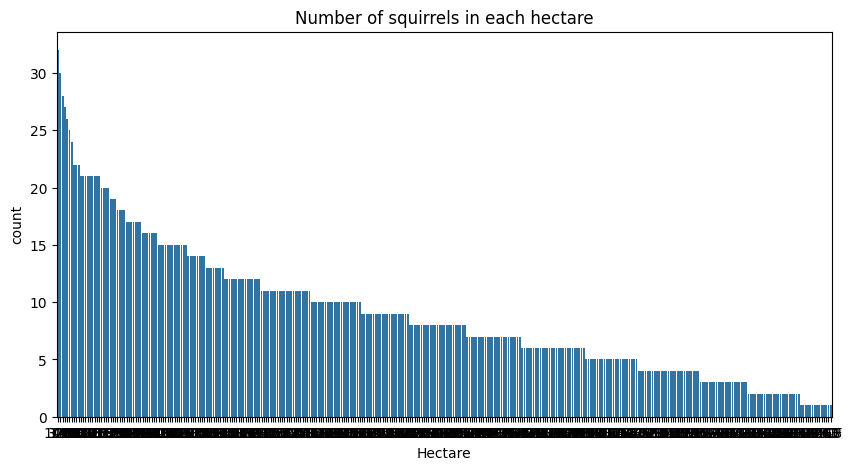

In [4]:

# Load the data
census, ad_viz, co2air, disease, no2, pbair, weather = load_data()

#plot of the number of squirrels in each hectare
def plot_squirrel_density(census):
    #plot the number of squirrels in each hectare
    plt.figure(figsize=(10,5))
    sns.countplot(x='Hectare', data=census, order=census['Hectare'].value_counts().index)
    plt.title('Number of squirrels in each hectare')
    plt.show()


plot_squirrel_density(census)
    

In [5]:
percent_missing = census.isnull().mean() * 100
missing_value_df = pd.DataFrame({'column_name': census.columns,
                                 'percent_missing': percent_missing})

print(missing_value_df)


                                                                           column_name  \
X                                                                                    X   
Y                                                                                    Y   
Unique Squirrel ID                                                  Unique Squirrel ID   
Hectare                                                                        Hectare   
Shift                                                                            Shift   
Date                                                                              Date   
Hectare Squirrel Number                                        Hectare Squirrel Number   
Age                                                                                Age   
Primary Fur Color                                                    Primary Fur Color   
Highlight Fur Color                                                Highlight Fur Color   
Combinatio

---
Going through the census data we have found that there is a large percentage of missing values in the columns for :
* Color notes 
* Specific Location    
* Other Activities
* Other Interactions  
* Highlight Fur Color 

These columns have 80-90% missing values  with highlight fur color having the lowest ammount with 35% missing values. The location, activites, and interactions are all what the recorders observed and will not be in a format that can be easily usable without modification. It is possible to use a vector search and see if there are any correlations based on the language used but this will not be used as a primary focus for finding corelations at the moment. 

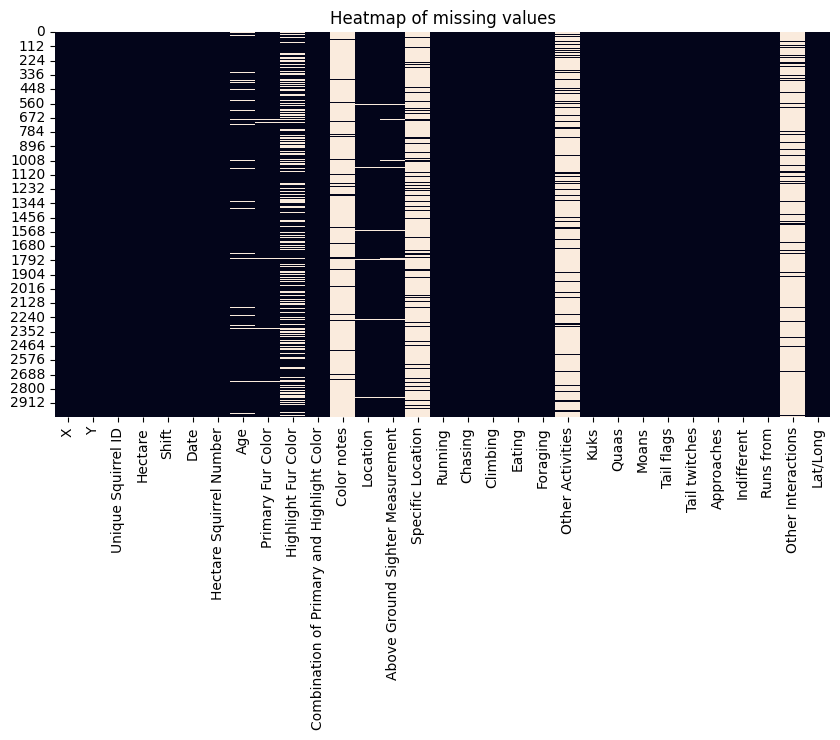

In [6]:
#heatmap of missing values
plt.figure(figsize=(10,5))
sns.heatmap(census.isnull(), cbar=False)
plt.title('Heatmap of missing values')
plt.show()


In [7]:
#create a list of unique values in other activities and other interactions 
other_activities = census['Other Activities'].unique()
other_interactions = census['Other Interactions'].unique()

# print the unique values in other activities and other interactions
print(other_activities)
print(other_interactions)


[nan 'grooming' 'walking' 'moving slowly' 'sitting'
 'eating (ate upside down on a tree — #jealous)' 'wrestling with mother'
 'running (with nut)' 'playing with #5' 'hiding nut'
 'drank from a pond of rain water' 'chasing (#4 across trees)'
 'gathering acorns'
 'eating (a mushroom),circles around us,really fat,scratching himself,grooming activity'
 'digging' 'walking on branch' 'being chased,was pushed by other squirrel'
 'climbing (tree)' 'chasing #8' 'still' 'stop to look at me—then ran'
 'chasing (a chipmunk)' 'took nut to bury' 'flying'
 'stole (found?) an entire sandwich' 'walking w/ something in mouth'
 'burying nut' 'begging' 'was hanging out w/ #2 until i showed up'
 'quietly' 'nest building' 'burying' 'dead (something ran over it)'
 'chased #12' 'playing (with #9)' 'sitting still' 'posing'
 'sitting in tree' 'together w/ #7' 'not sure walk-pause-walk' 'jumping'
 'eating (mushroom)'
 'eating (eats with head tilted far to the right (tooth issue?))'
 'playing tag together' 'pranc

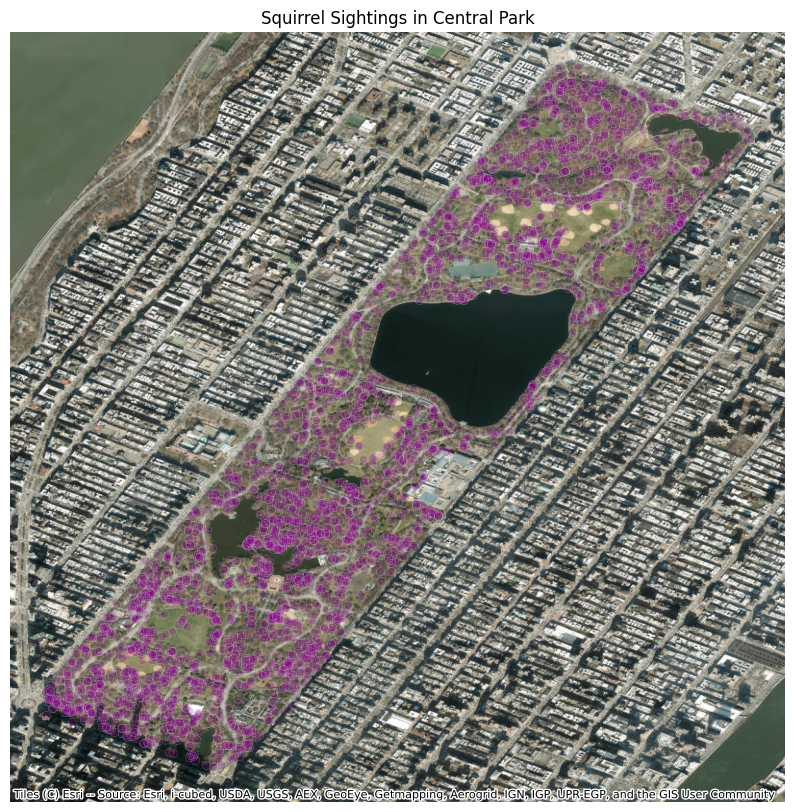

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import pandas as pd

def plot_squirrel_map(census):
    # Create a GeoDataFrame for the census data
    gdf = gpd.GeoDataFrame(census, geometry=gpd.points_from_xy(census.X, census.Y))
    gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84 CRS for input data
    
    # Convert the GeoDataFrame to Web Mercator for compatibility with basemaps
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the scatterplot for squirrel sightings
    sns.scatterplot(x=gdf.geometry.x, y=gdf.geometry.y, data=gdf, alpha=0.2, ax=ax, color="purple")

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Customize the plot
    ax.set_title('Squirrel Sightings in Central Park')
    ax.set_axis_off()

    # Show the plot
    plt.show()

# Provided points

data3 = census[['X', 'Y']]
# Call the function
plot_squirrel_map(data3)


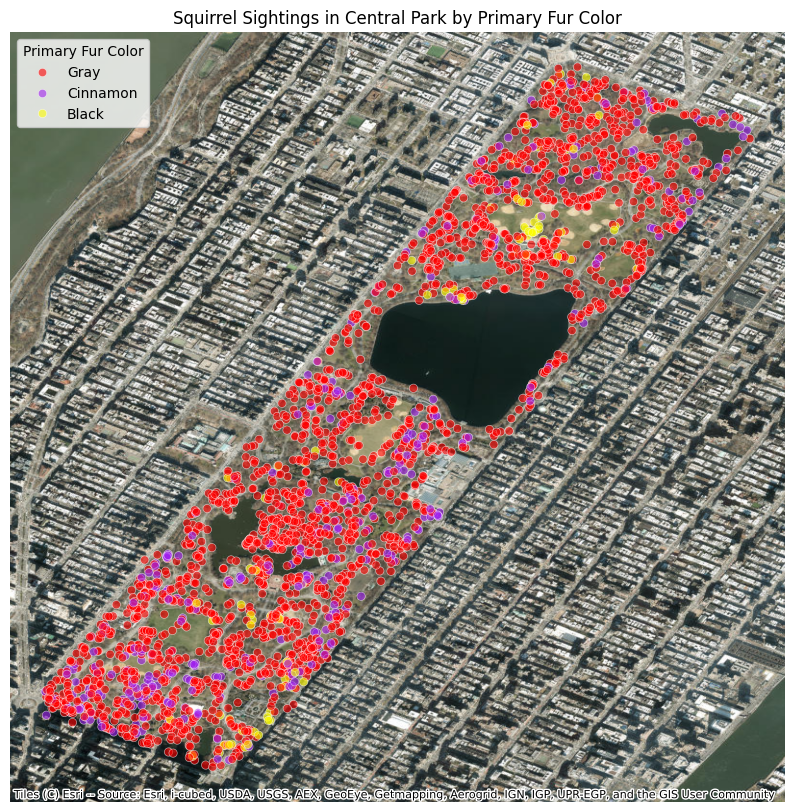

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

def plot_squirrel_map_with_custom_palette(census, custom_palette):
    # Create a GeoDataFrame for the census data
    gdf = gpd.GeoDataFrame(census, geometry=gpd.points_from_xy(census.X, census.Y))
    gdf = gdf.set_crs(epsg=4326)  # Assuming WGS84 CRS for input data
    
    # Convert the GeoDataFrame to Web Mercator for compatibility with basemaps
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the scatterplot for squirrel sightings with custom palette
    sns.scatterplot(
        x=gdf.geometry.x, 
        y=gdf.geometry.y, 
        data=gdf, 
        hue="Primary Fur Color", 
        alpha=0.6, 
        ax=ax, 
        palette=custom_palette  # Custom color palette
    )

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    # Customize the plot
    ax.set_title('Squirrel Sightings in Central Park by Primary Fur Color')
    ax.set_axis_off()

    # Show the plot
    plt.show()

# Define a custom palette (example)
custom_palette = {
    "Gray": "#ff0000",       # Red
    "Cinnamon": "#a020f0",   # Purple (example, you can adjust this)
    "Black": "#ffff00",      # Black
}


# Call the function with your census data and custom palette
plot_squirrel_map_with_custom_palette(census, custom_palette)


In [10]:
# Load your data
census, ad_viz, co2air, disease, no2, pbair, weather = load_data()

# Clean disease data (list of IDs)
diseased_ids = disease[0].tolist()

# Create a 'Diseased' column in the census data
census['Diseased'] = census['Unique Squirrel ID'].isin(diseased_ids)


In [11]:
# Compare age distribution
age_counts = census.groupby(['Age', 'Diseased']).size().unstack()
print(age_counts)

# Chi-squared test for fur color

fur_color_table = pd.crosstab(census['Primary Fur Color'], census['Diseased'])
chi2, p, dof, ex = chi2_contingency(fur_color_table)
print(f"P-value for fur color difference: {p}")


Diseased   False  True 
Age                    
?            4.0    NaN
Adult     2273.0  295.0
Juvenile   311.0   19.0
P-value for fur color difference: 5.944483338009056e-248


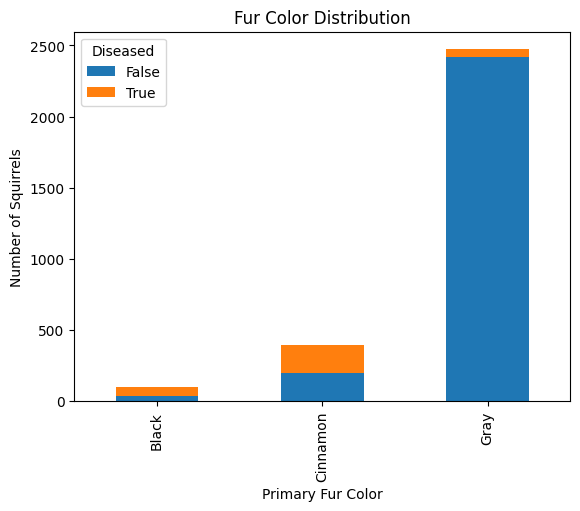

In [12]:
# Bar chart for fur color
fur_color_counts = census.groupby(['Primary Fur Color', 'Diseased']).size().unstack()
fur_color_counts.plot(kind='bar', stacked=True)
plt.title('Fur Color Distribution')
plt.xlabel('Primary Fur Color')
plt.ylabel('Number of Squirrels')
plt.show()


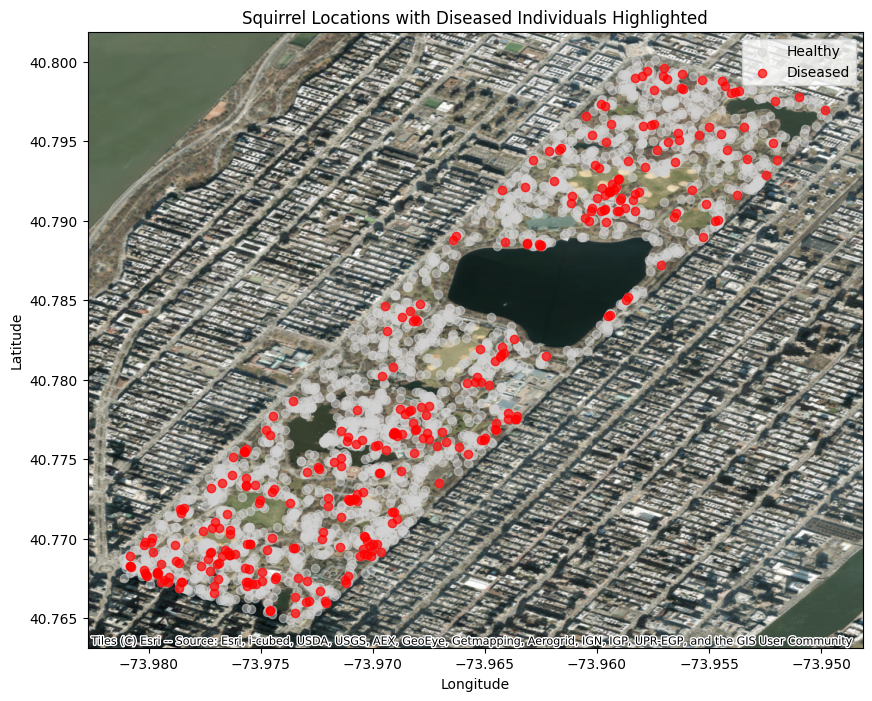

In [13]:
import matplotlib.pyplot as plt
import contextily as ctx

# Create a figure
plt.figure(figsize=(10, 8))

# Plot all squirrels
plt.scatter(census['X'], census['Y'], c='lightgrey', label='Healthy', alpha=0.5)

# Highlight diseased squirrels
diseased_squirrels = census[census['Diseased']]
plt.scatter(diseased_squirrels['X'], diseased_squirrels['Y'], c='red', label='Diseased', alpha=0.7)

# Add satellite basemap using contextily
ax = plt.gca()
ctx.add_basemap(
    ax,
    crs='EPSG:4326',  # Coordinate reference system used by census data
    source=ctx.providers.Esri.WorldImagery  # Satellite imagery
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Squirrel Locations with Diseased Individuals Highlighted')
plt.legend()
plt.show()


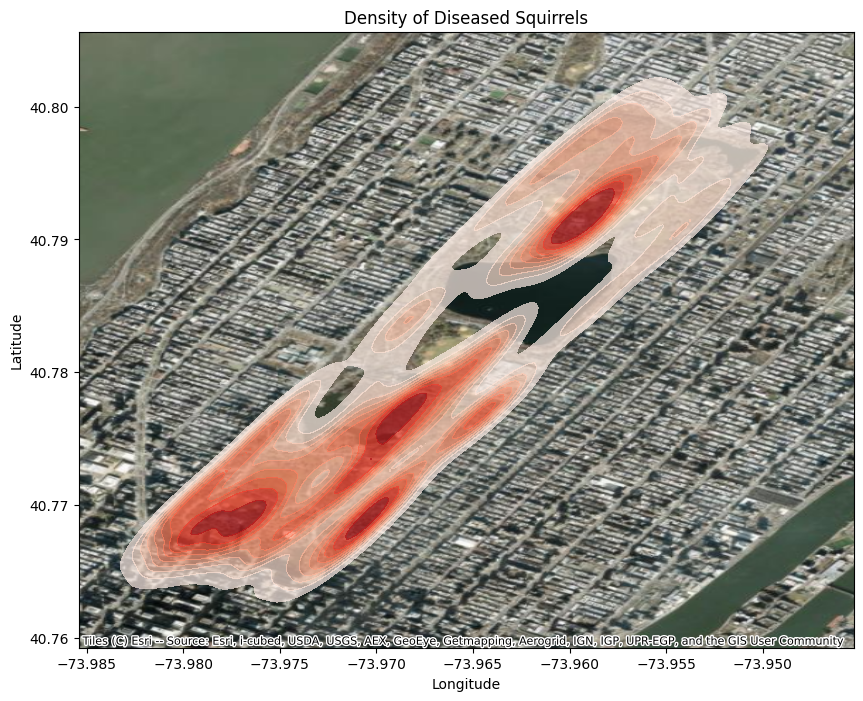

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

# Create the plot
plt.figure(figsize=(10, 8))

# KDE plot for diseased squirrels
sns.kdeplot(
    x=diseased_squirrels['X'], 
    y=diseased_squirrels['Y'], 
    cmap="Reds", 
    shade=True, 
    bw_adjust=0.5, 
    alpha=0.7
)

# Add satellite basemap using contextily
ax = plt.gca()
ctx.add_basemap(
    ax,
    crs='EPSG:4326',  # Coordinate reference system
    source=ctx.providers.Esri.WorldImagery  # Satellite imagery
)

plt.title('Density of Diseased Squirrels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [15]:
# plot the percentage of squirrels that are diseased and not diseased by behavior
behaviors = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']









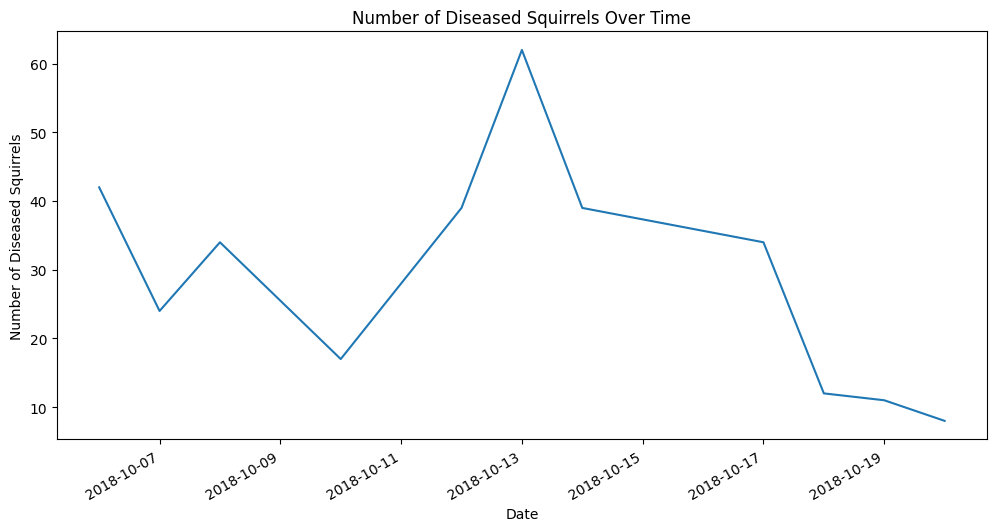

In [16]:
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')

# Time series plot
census.set_index('Date', inplace=True)
disease_time_series = census.groupby('Date')['Diseased'].sum()

plt.figure(figsize=(12, 6))
disease_time_series.plot()
plt.title('Number of Diseased Squirrels Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Diseased Squirrels')
plt.show()


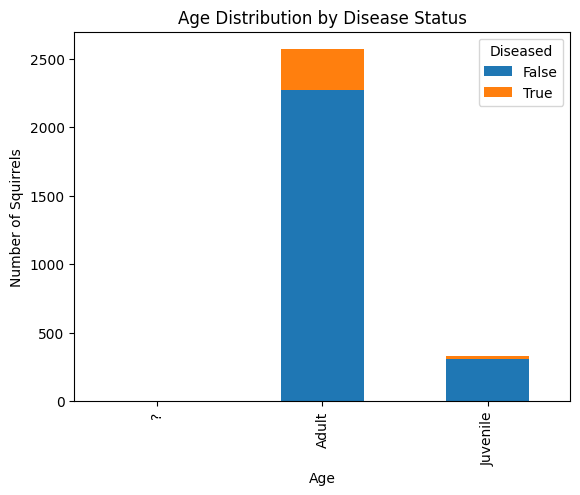

<Axes: title={'center': 'Percent of Squirrels Diseased by Age'}, xlabel='Age'>

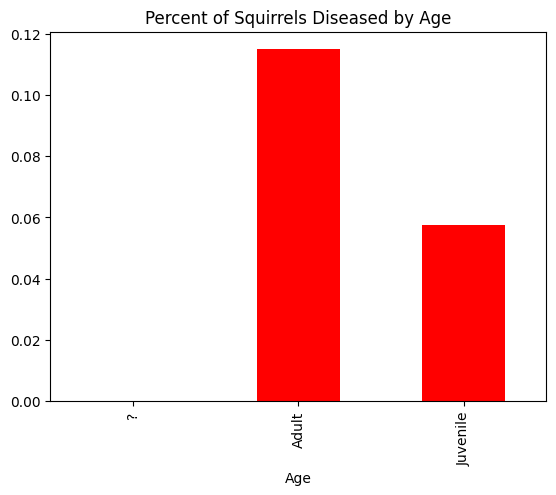

In [34]:
age_counts = census.groupby(['Age', 'Diseased']).size().unstack()
age_counts.plot(kind='bar', stacked=True)
plt.title('Age Distribution by Disease Status')
plt.xlabel('Age')
plt.ylabel('Number of Squirrels')
plt.show()

#get percent of squirrels that are diseased by age
age_counts['Percent Diseased'] = age_counts[True] / age_counts.sum(axis=1)
age_counts['Percent Diseased'].plot(kind='bar', color='red', title='Percent of Squirrels Diseased by Age')


In [18]:
# find the percentage of dieased squirrels with Other Activities, and Other Interactions and list the 
# activities and interactions where diseased squirrels are more than 50% of the total number of squirrels

# Percentage of diseased squirrels with Other Activities
other_activities_counts = census.groupby(['Other Activities', 'Diseased']).size().unstack()
other_activities_counts['Percentage Diseased'] = other_activities_counts[True] / other_activities_counts.sum(axis=1)
print(other_activities_counts)

# Percentage of diseased squirrels with Other Interactions
other_interactions_counts = census.groupby(['Other Interactions', 'Diseased']).size().unstack()
other_interactions_counts['Percentage Diseased'] = other_interactions_counts[True] / other_interactions_counts.sum(axis=1)
print(other_interactions_counts)

# Activities where diseased squirrels are more than 50% of the total number of squirrels
activities_over_50 = other_activities_counts[other_activities_counts['Percentage Diseased'] > 0.5]
print(activities_over_50)

# Interactions where diseased squirrels are more than 50% of the total number of squirrels
interactions_over_50 = other_interactions_counts[other_interactions_counts['Percentage Diseased'] > 0.5]
print(interactions_over_50)





Diseased                                False  True  Percentage Diseased
Other Activities                                                        
#7 & #8 chased each other up diff tree    1.0   NaN                  NaN
2/3 chasing each other                    2.0   NaN                  NaN
2/3 were chasing each other               2.0   NaN                  NaN
a lot of activity                         1.0   NaN                  NaN
acorns                                    1.0   NaN                  NaN
...                                       ...   ...                  ...
watching passers-by                       1.0   NaN                  NaN
with some nuts in the mouth               1.0   NaN                  NaN
wresting w/ branch                        1.0   NaN                  NaN
wrestling with child                      NaN   1.0                  1.0
wrestling with mother                     1.0   NaN                  NaN

[307 rows x 3 columns]
Diseased                   

---
To see if there could be a correlation between the 

In [19]:
print(weather.head())

       STATION                         NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
1  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
2  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
3  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
4  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   

         DATE  AWND AWND_ATTRIBUTES    FMTM FMTM_ATTRIBUTES  ...  WT16  \
0  2010-12-31  6.04             ,,W  2124.0             ,,X  ...   NaN   
1  2011-01-01  3.13             ,,W     1.0             ,,X  ...   NaN   
2  2011-01-02  5.14             ,,W  2232.0             ,,X  ...   1.0   
3  2011-01-03  8.72             ,,W   222.0             ,,X  ...   NaN   
4  2011-01-04  6.26             ,,W  1715.0             ,,X  ...   NaN   

  WT16_ATTRIBUTES  WT17 WT17_ATTRIBUTES  WT18 WT18_ATTRIBUTES  WT19  \
0        

In [20]:
# Reset index to access 'Date' column
census.reset_index(inplace=True)

# Convert date column in census and weather data to datetime
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')

# Merge the census and weather data on the date column
census_weather = pd.merge(census, weather, left_on='Date', right_on='DATE', how='inner')

# Align date range to census data
census_weather = census_weather[(census_weather['Date'] >= '2018-10-01') & (census_weather['Date'] <= '2018-10-31')]

print(census_weather.head())


        Date          X          Y Unique Squirrel ID Hectare Shift  \
0 2018-10-14 -73.956134  40.794082     37F-PM-1014-03     37F    PM   
1 2018-10-19 -73.968857  40.783783     21B-AM-1019-04     21B    AM   
2 2018-10-14 -73.974281  40.775534     11B-PM-1014-08     11B    PM   
3 2018-10-17 -73.959641  40.790313     32E-PM-1017-14     32E    PM   
4 2018-10-17 -73.970268  40.776213     13E-AM-1017-05     13E    AM   

   Hectare Squirrel Number    Age Primary Fur Color Highlight Fur Color  ...  \
0                        3    NaN               NaN                 NaN  ...   
1                        4    NaN               NaN                 NaN  ...   
2                        8    NaN              Gray                 NaN  ...   
3                       14  Adult              Gray                 NaN  ...   
4                        5  Adult              Gray            Cinnamon  ...   

  WT16 WT16_ATTRIBUTES WT17 WT17_ATTRIBUTES WT18  WT18_ATTRIBUTES  WT19  \
0  NaN           

In [21]:
#create a correlation matrix of the census_weather data and plot a heatmap of the correlation matrix

#select only the numeric columns
census_weather_numeric = census_weather.select_dtypes(include=[np.number])




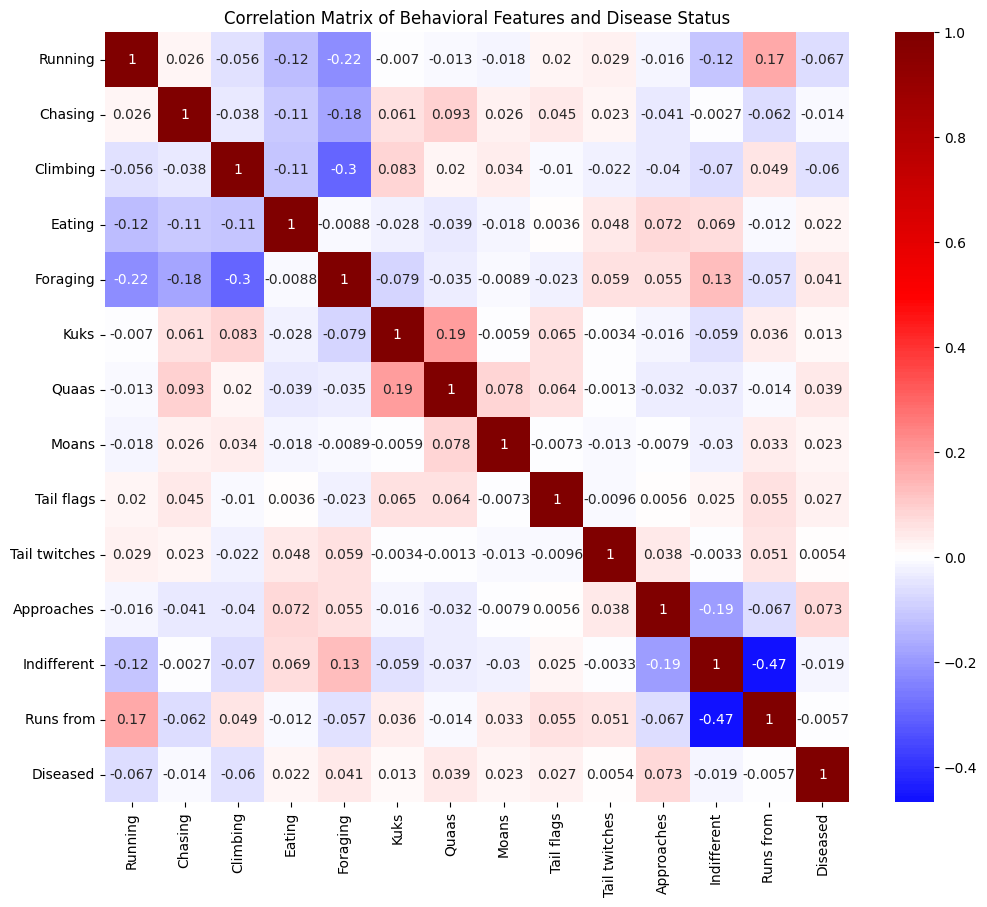

In [22]:
# correlation matrix of behavioral features and the 'Diseased' column

#select only the behavioral features and the 'Diseased' column

behavioral_features = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging','Kuks','Quaas','Moans','Tail flags','Tail twitches','Approaches','Indifferent','Runs from']

behavioral_features_diseased = census_weather[behavioral_features + ['Diseased']]
behavioral_features_diseased = behavioral_features_diseased.dropna()

correlation_matrix = behavioral_features_diseased.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title('Correlation Matrix of Behavioral Features and Disease Status')
plt.show()


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Replace NaN values with an empty string
census_weather['Other Activities'] = census_weather['Other Activities'].fillna("")
census_weather['Other Interactions'] = census_weather['Other Interactions'].fillna("")
census_weather['Specific Location'] = census_weather['Specific Location'].fillna("")


# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'Other Activities' column
other_activities_tfid = vectorizer.fit_transform(census_weather['Other Activities'])

other_interactions_tfid = vectorizer.fit_transform(census_weather['Other Interactions'])

specific_location_tfid = vectorizer.fit_transform(census_weather['Specific Location'])

In [24]:
# Combine the 'Age' and 'Primary Fur Color' columns to create a stratification group
census_weather['Stratify_Group'] = census_weather['Age'].astype(str) + "_" +\
      census_weather['Primary Fur Color'].astype(str)


In [25]:
#drop columns that have 100% missing values
census_weather = census_weather.dropna(axis=1, how='all')

In [26]:


# list of features to drop
features_to_drop = ['X', 'Y', 'Shift', 'STATION','NAME','LATITUDE','LONGITUDE',
                    'ELEVATION','PRCP_ATTRIBUTES','SNOW','SNOW_ATTRIBUTES','SNWD'
                    ,'SNWD_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','WT01','WT01_ATTRIBUTES',
                    'AWND_ATTRIBUTES','PRCP_ATTRIBUTES','WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES',
                    'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES','WT08', 'WT08_ATTRIBUTES']


# function to drop the features
def drop_features(data, features_to_drop):
    data = data.drop(features_to_drop, axis=1)
    return data



In [27]:
census_weather = drop_features(census_weather, features_to_drop)



| Vector             | OneHot                                     | Numerical                                                     | Other                   |   |
|--------------------|--------------------------------------------|---------------------------------------------------------------|-------------------------|---|
| Color notes        | Age                                        | Above Ground Sighter Measurement  (need to change false to 0) | Unique Squirrel ID      |   |
| Specific Location  | Primary Fur Color                          | AWND                                                          | Hectare                 |   |
| Other Activities   | Highlight Fur Color                        | PRCP                                                          | Date                    |   |
| Other Interactions | Combination of Primary and Highlight Color | TMAX                                                          | Hectare Squirrel Number |   |
|                    | Location                                   | TMIN                                                          | Lat/Long                |   |
|                    | Running                                    | WDF2                                                          |                         |   |
|                    | Chasing                                    | WDF5                                                          |                         |   |
|                    | Climbing                                   | WSF2                                                          |                         |   |
|                    | Eating                                     | WSF5                                                          |                         |   |
|                    | Foraging                                   | Hectare Squirrel Number                                       |                         |   |
|                    | Kuks                                       |                                                               |                         |   |
|                    | Quaas                                      |                                                               |                         |   |
|                    | Moans                                      |                                                               |                         |   |
|                    | Tail flags                                 |                                                               |                         |   |
|                    | Tail twitches                              |                                                               |                         |   |
|                    | Approaches                                 |                                                               |                         |   |
|                    | Indifferent                                |                                                               |                         |   |
|                    | Runs from                                  |                                                               |                         |   |
|                    | Diseased                                   |                                                               |                         |   |
|                    |                                            |                                                               |                         |   |

Features with missing values are:
* Age
 121
Primary Fur Color
55
Highlight Fur Color
1,086
Color notes
2,841
Location
64
Above Ground Sighter Measurement
114
Specific Location
2,547
Other Activities
2,586
Other Interactions
2,783
AWND
1,443
WDF2
1,443
WDF5
1,443
WSF2
1,443
WSF5
1,443

In [28]:
print(census_weather.dtypes)

Date                                          datetime64[ns]
Unique Squirrel ID                                    object
Hectare                                               object
Hectare Squirrel Number                                int64
Age                                                   object
Primary Fur Color                                     object
Highlight Fur Color                                   object
Combination of Primary and Highlight Color            object
Color notes                                           object
Location                                              object
Above Ground Sighter Measurement                      object
Specific Location                                     object
Running                                                 bool
Chasing                                                 bool
Climbing                                                bool
Eating                                                  bool
Foraging                

-----
# Pipeline 

In [37]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.preprocessing._function_transformer')
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Copy the data
data = census_weather.copy()

# Columns to drop
columns_to_drop = ['Unique Squirrel ID', 'Lat/Long']
X = data.drop(columns=['Diseased'] + columns_to_drop)
y = data['Diseased']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Functions to be used in the pipeline


class DateMergerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Convert 'Date' and 'DATE' to datetime, handling errors
        X['Date'] = pd.to_datetime(X['Date'], errors='coerce')
        X['DATE'] = pd.to_datetime(X['DATE'], errors='coerce')

        # Combine the dates, prioritizing non-null values
        X['MergedDate'] = X[['Date', 'DATE']].max(axis=1)

        # Extract date features
        date_features = pd.DataFrame({
            'year': X['MergedDate'].dt.year,
            'month': X['MergedDate'].dt.month,
            'day': X['MergedDate'].dt.day,
            'weekday': X['MergedDate'].dt.weekday
        })

        # Handle missing values by filling with zeros
        date_features = date_features.fillna(0)

        # Reset index to align with other data
        return date_features.reset_index(drop=True)


class BoolTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        boolean_columns = [
            'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks',
            'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches',
            'Indifferent', 'Runs from'
        ]
        X[boolean_columns] = X[boolean_columns].astype(int)
        return X

class PreprocessBooleansAboveGroundTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No hyperparameters to initialize

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()
        # Replace 'FALSE' with 0 in 'Above Ground Sighter Measurement'
        X['Above Ground Sighter Measurement'] = X['Above Ground Sighter Measurement'].replace('FALSE', 0)

        # Convert 'Above Ground Sighter Measurement' to numeric
        X['Above Ground Sighter Measurement'] = pd.to_numeric(X['Above Ground Sighter Measurement'], errors='coerce')

        # Convert boolean columns to integers (0 for False, 1 for True)
        boolean_columns = [
            'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks',
            'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches',
            'Indifferent', 'Runs from'
        ]
        X[boolean_columns] = X[boolean_columns].astype(int)

        return X

def combine_text_columns(X):
    combined_series = X.fillna('missing').agg(' '.join, axis=1)
    return combined_series.to_frame(name='combined_text')

def extract_combined_text(X):
    return X['combined_text']
# Define column groups
boolean_columns = [
    'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas',
    'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from'
]

numerical_columns = [
    'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
    'Hectare Squirrel Number', 'Above Ground Sighter Measurement'
]

one_hot_columns = [
    'Primary Fur Color', 'Location', 'Highlight Fur Color', 'Age',
    'Hectare', 'Combination of Primary and Highlight Color'
]

text_columns = [
    'Other Activities', 'Other Interactions', 'Specific Location', 'Color notes'
]

# Convert text columns to string type
X_train[text_columns] = X_train[text_columns].astype(str)
X_test[text_columns] = X_test[text_columns].astype(str)


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

text_transformer = Pipeline(steps=[
    ('combine_text', FunctionTransformer(combine_text_columns, validate=False)),
    ('extract_text', FunctionTransformer(extract_combined_text, validate=False)),
    ('tfidf', TfidfVectorizer(max_features=5000))
])

boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('bool_to_int', BoolTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, one_hot_columns),
        ('bool', boolean_transformer, boolean_columns),
        ('text', text_transformer, text_columns),
        ('date', DateMergerTransformer(), ['Date', 'DATE'])
    ],
    remainder='drop'  # Exclude unhandled columns
)

# Build the pipeline with the new transformer
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Remove external preprocessing calls
# X_train = preprocess_booleans_above_ground(X_train)
# X_test = preprocess_booleans_above_ground(X_test)

# Fit the pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess_booleans',
                 PreprocessBooleansAboveGroundTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['AWND', 'PRCP', 'TMAX',
                                                   'TMIN', 'WDF2', 'WDF5',
                                                   'WSF2', 'WSF5',
                                                   'Hectare Squirrel Number',
                                                   'Above Ground Sighter '
                                                   'Measurement']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(s...
                                                                   FunctionTransformer(func=<function combine_text_columns at 0x1413c7b00>)),
                                                                  ('extract_text',
                                                                   FunctionTransformer(func=<function extract_combined_text at 0x1413c5f80>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000))]),
                                                  ['Other Activities',
                                                   'Other Interactions',
                                                   'Specific Location',
                                                   'Color notes']),
                                                 ('date',
                                                  DateMergerTransformer(),
                                                  ['Date', 'DATE'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [30]:
X_train.head()

Date Hectare  Hectare Squirrel Number    Age Primary Fur Color  \
2067 2018-10-14     03H                        1  Adult              Gray   
2632 2018-10-10     04C                        9  Adult              Gray   
199  2018-10-10     31A                        5  Adult              Gray   
283  2018-10-12     11G                        1  Adult              Gray   
231  2018-10-14     14A                        1  Adult              Gray   

     Highlight Fur Color Combination of Primary and Highlight Color  \
2067                 NaN                                      Gray+   
2632               White                                 Gray+White   
199                  NaN                                      Gray+   
283             Cinnamon                              Gray+Cinnamon   
231      Cinnamon, White                       Gray+Cinnamon, White   

     Color notes      Location Above Ground Sighter Measurement  ...  \
2067         nan  Ground Plane                            FALSE  ...   
2632         nan  Ground Plane                            FALSE  ...   
199          nan  Ground Plane                            FALSE  ...   
283          nan  Ground Plane                            FALSE  ...   
231          nan  Ground Plane                            FALSE  ...   

           DATE  AWND  PRCP  TMAX  TMIN   WDF2   WDF5  WSF2  WSF5  \
2067 2018-10-14   NaN  0.00    58    47    NaN    NaN   NaN   NaN   
2632 2018-10-10  2.68  0.00    80    71  260.0  230.0   8.1  14.1   
199  2018-10-10  2.68  0.00    80    71  260.0  230.0   8.1  14.1   
283  2018-10-12  5.82  0.43    68    51  290.0  300.0  16.1  30.0   
231  2018-10-14   NaN  0.00    58    47    NaN    NaN   NaN   NaN   

      Stratify_Group  
2067      Adult_Gray  
2632      Adult_Gray  
199       Adult_Gray  
283       Adult_Gray  
231       Adult_Gray  

[5 rows x 36 columns]

In [31]:
#run the pipeline on the test data with a logistic regression classifier
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)

# Predict on the test data

y_pred = pipeline.predict(X_test)



#get recall 
precision = precision_score(y_test, y_pred)
print(f"precision: {precision}")
# get cross validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Recall: {cv_score.mean()}")

precision: 0.48148148148148145
Cross-validation Recall: 0.5422753716871364


In [32]:
# Grid search on logistic regression
param_grid = {
    'classifier__C': [0.01, 0.001, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters



Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be de

[CV] END .........classifier__C=0.01, classifier__penalty=l2; total time=   0.6s
[CV] END ........classifier__C=0.001, classifier__penalty=l2; total time=   0.7s
[CV] END .........classifier__C=0.01, classifier__penalty=l2; total time=   0.7s
[CV] END .........classifier__C=0.01, classifier__penalty=l2; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be de

[CV] END ........classifier__C=0.001, classifier__penalty=l2; total time=   0.9s
[CV] END .........classifier__C=0.01, classifier__penalty=l2; total time=   1.1s
[CV] END .........classifier__C=0.01, classifier__penalty=l2; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
print(f"Best parameters: {grid_search.best_params_}") # Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}

#print the best recall score
print(f"Best Precision Score: {grid_search.best_score_}")

In [ ]:
# try a random forest classifier
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')

print(f"Cross-validation Recall: {cv_score.mean()}")

In [ ]:
# run the gridsearch on the random forest classifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4], 
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


In [ ]:
#get the best parameters
print(f"Best parameters: {grid_search.best_params_}") # Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 
                                                    #'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 
                                                    # 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
#get the best recall score
print(f"Best Recall Score: {grid_search.best_score_}")

In [ ]:
# Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}

pipeline2 = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=300, max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, bootstrap=True, random_state=42))
])

pipeline2.fit(X_train, y_train)

y_pred = pipeline2.predict(X_test)

precision = precision_score(y_test, y_pred)

print(f"Precision: {precision}")

cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')

print(f"Cross-validation Precission: {cv_score.mean()}")


#get the recall score
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# get the f1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

#get cross vals of each
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")


In [ ]:
# use the svm classifier
from sklearn.svm import SVC

pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

precision = precision_score(y_test, y_pred)

print(f"Precisoin: {precision}")
#print cros validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")

In [75]:
# # grid search on the svc classifier
# # Becaues SVC preformed poorly, and GridSearchCV is computationally expensive, we will skip GridSearch for 
# # the SVC classifier
# param_grid = {
#     'classifier__C': [0.1, 1, 10],
#     'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'classifier__degree': [2, 3, 4],
#     'classifier__gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall',
#                             n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# #get the best parameters
# print(f"Best parameters: {grid_search.best_params_}")
# #get the best recall score
# print(f"Best Recall Score: {grid_search.best_score_}")


In [ ]:
# # SGDClassifier
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# print cross validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# print cross validation score

cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')

print(f"Cross-validation Recall: {cv_score.mean()}")

In [ ]:
# preform grid search on the extra trees classifier
grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='recall',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


In [ ]:
#get the best parameters
print(f"Best parameters: {grid_search.best_params_}")
#get the best recall score
print(f"Best Precision Score: {grid_search.best_score_}")


In [ ]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
#get cross vals 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Precision: {cv_score.mean()}")
#Get f1 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
# f1 cross val 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")

In [ ]:
"""
Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best Precision Score: 0.8800000000000001

"""

pipeline2 = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(n_estimators=300, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=42))
])

pipeline2.fit(X_train, y_train)

y_pred = pipeline2.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
#get cross vals 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-validation Recall: {cv_score.mean()}")
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Precision: {cv_score.mean()}")
#Get f1 
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
# f1 cross val 
cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")


In [ ]:
# # GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

# print cross validation score

cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')

print(f"Cross-validation Recall: {cv_score.mean()}")

#get f1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")
#f1 cross val
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1 Score: {cv_score.mean()}")
# get precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Precision: {cv_score.mean()}")


In [ ]:
#preform grid search on the gradient boosting classifier 
grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring='f1',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)



In [ ]:
# get the best parameters
print(f"Best parameters: {grid_search.best_params_}")
#get the best recall score
print(f"Best F1 Score: {grid_search.best_score_}")

In [40]:
#Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
# run the pipeline with the best parameters
from sklearn.ensemble import GradientBoostingClassifier
pipeline2 = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, random_state=42))
])

pipeline2.fit(X_train, y_train)

y_pred = pipeline2.predict(X_test)

recall = recall_score(y_test, y_pred)

print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

precision = precision_score(y_test, y_pred)

print(f"Precision: {precision}")

cv_score = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='recall')
cv_score2 = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='f1')
cv_score3 = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Recall: {cv_score.mean()}")
print(f"Cross-validation F1 Score: {cv_score2.mean()}")
print(f"Cross-validation Precision: {cv_score3.mean()}")

Recall: 0.45614035087719296
F1 Score: 0.5048543689320388
Precision: 0.5652173913043478
Cross-validation Recall: 0.5962264150943396
Cross-validation F1 Score: 0.6564064198088294
Cross-validation Precision: 0.7327985177810962


In [262]:
import pickle

# Specify the filename for the serialized pipeline
filename = 'finalized_model.sav'

# Try to save the pipeline
try:
    with open(filename, 'wb') as file:
        pickle.dump(pipeline2, file)
    print(f"Pipeline saved successfully to {filename}!")
except Exception as e:
    print(f"Error saving pipeline: {e}")


Pipeline saved successfully to finalized_model.sav!


[[2096   57]
 [ 107  158]]


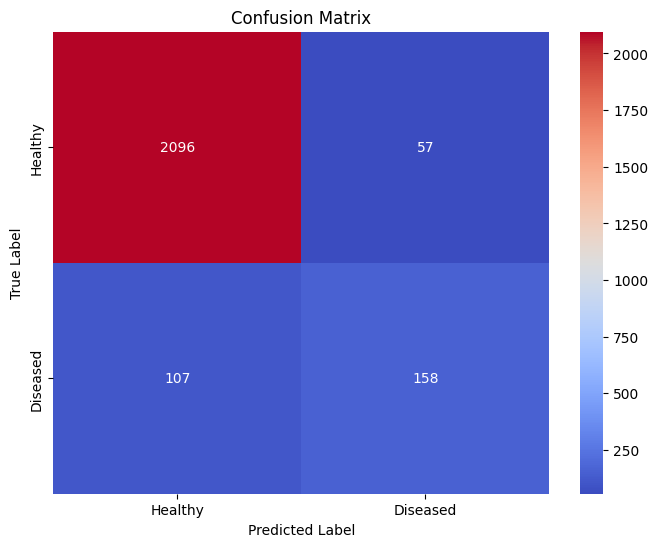

In [45]:
# create a confusion matrix for the pipeline2 based on the cross validation data 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(pipeline2, X_train, y_train, cv=5)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_cv)
print(conf_matrix)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Healthy', 'Diseased'])
plt.yticks(ticks=[0.5, 1.5], labels=['Healthy', 'Diseased'])
plt.show()



# Squirrel's will be rescued!!!
<!-- Recall: 0.45614035087719296
F1 Score: 0.5048543689320388
Precision: 0.5652173913043478
Cross-validation Recall: 0.5962264150943396
Cross-validation F1 Score: 0.6564064198088294
Cross-validation Precision: 0.7327985177810962
-->
Based on the data collected, there seems to be a pattern that will allow us to predict weather or not a squirrel is sick. However we can not guarantee you that the squirrels that are claimed to be diseased are in fact diseased. I would like you to think about it this way, 73% of the time you send one of your employees out to capture a identified squirrel, that squirrel will in fact be diseased. And our model will be able to identify 65% of all diseased squirrels. For your information we primarily used data from the government of ny about the squirrel census and combined it with data from a federal weather tracker. Below are some images that I have that will allow me to further explain our findings.

## Density of Diseased Squirrels in Central Park

Below is a map of Central Park with the density of diseased squirrels in the park. The darker the color the more dead squirrels are in that area. 

<!-- show density.png -->
### ![Density Map](density.png)

This map can allow you to see where to focus your efforts in capturing the diseased squirrels.

## Fur Color of Diseased Squirrels

Below is another map of fur color based on sightings. 

### ![Fur Color Map](furcolor.png)

This map can allow you to see if there is a correlation between fur color and the disease. when combined with other images provided to you.


Knowing where the diseased squirrels are can be a huge advantage in capturing them. Below is another map that shows the density of squirrels in the park.

### ![Density Map](density.png)

This map can allow you to see where to focus your efforts in capturing the diseased squirrels.


I think it is also important for you to know that there is a significant difference between the percent 
of diseased squirrels based on the age of the squirrel. Below there is a bar graph that shows you the proportion of diseased squirrels based on the age of the squirrel. It shows us that adult squirrels are more likely to be diseased than juvenile squirrels, but I would like to remind you that this is based on the data that we have collected and may not be accurate. It also remains important to be aware that no formal testing has been done to confirm if the percent difference is statistically significant.

### ![Age](percentDiseased.png)


Finally I would like to show you a confusion matrix that shows the performance of our model. A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known.

### ![Confusion Matrix](confusion.png)

The confusion matrix shows us that our model is able to correclty identify most squirrels. It is also relatively unlikely that a squirrel that is not diseased will be marked as diseased. This is important because it means that we are not wasting resources on capturing squirrels that are not diseased.


If you have any questions or would like to see more data please let me know. You can reach me at 555-555-5555 or email me at dontemailme@Imnotreal.com